In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from tqdm import tqdm
import fasttext
import fasttext.util
from sklearn.preprocessing import MultiLabelBinarizer
import re
from typing import List, Dict, Any, Tuple
import urllib.request
import sys
import gzip
import shutil
from scipy.spatial.distance import jaccard

def preprocess_text(text: str) -> str:
    """
    Preprocess text for FastText embedding.
    """
    # Convert to lowercase
    text = text.lower()
    # Replace newlines and tabs with spaces
    text = re.sub(r'[\n\t]', ' ', text)
    # Remove special characters but keep letters, numbers and spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def download_with_progress(url: str, output_path: str) -> None:
    """
    Download a file with a tqdm progress bar.
    """
    try:
        print(f"Downloading from {url}")
        # Get content length from URL
        u = urllib.request.urlopen(url)
        total_size = int(u.info().get('Content-Length', 0))
        
        # Set up the tqdm progress bar
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
            def report_hook(count, block_size, total_size):
                pbar.update(block_size)
            
            # Download the file
            urllib.request.urlretrieve(url, output_path, reporthook=report_hook)
    except Exception as e:
        print(f"Error during download: {e}")
        # Try direct download without progress in case of error
        print("Attempting direct download...")
        urllib.request.urlretrieve(url, output_path)

def ensure_pretrained_vectors_downloaded(vector_file_name: str = 'cc.en.300.vec') -> str:
    """
    Ensures the FastText pre-trained vectors (.vec file) are downloaded and returns its path.
    """
    home_dir = os.path.expanduser("~")
    fasttext_dir = os.path.join(home_dir, ".fasttext")
    local_vector_path = os.path.join(os.getcwd(), vector_file_name)
    default_vector_path = os.path.join(fasttext_dir, vector_file_name)

    # Check various locations for the .vec file
    if os.path.exists(local_vector_path):
        print(f"Found pre-trained FastText vectors at {local_vector_path}")
        return local_vector_path
    elif os.path.exists(default_vector_path):
        print(f"Found pre-trained FastText vectors at {default_vector_path}")
        return default_vector_path
    else:
        print(f"Pre-trained FastText vectors ({vector_file_name}) not found, downloading...")

        # Ensure the FastText directory exists
        os.makedirs(fasttext_dir, exist_ok=True)

        # FastText download URL for English vectors (.vec.gz)
        gz_file_name = f"{vector_file_name}.gz"
        url = f"https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/{gz_file_name}"
        gz_path = os.path.join(fasttext_dir, gz_file_name)

        # Download with progress bar
        download_with_progress(url, gz_path)

        # Extract the gz file
        print(f"Extracting vector file to {default_vector_path}...")
        with gzip.open(gz_path, 'rb') as f_in:
            with open(default_vector_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        # Remove the gz file
        os.remove(gz_path)
        print(f"Vectors extracted to {default_vector_path}")

        # Try to create a symlink in current directory for convenience
        try:
            if not os.path.exists(local_vector_path):
                os.symlink(default_vector_path, local_vector_path)
                print(f"Created symlink to vectors in current directory")
        except (OSError, AttributeError) as e:
            print(f"Note: Could not create symlink in current directory: {e}")

        return default_vector_path

def ensure_pretrained_model_downloaded(model_name: str = 'cc.en.300.bin') -> str:
    """
    Ensures the FastText pre-trained model (.bin file) is downloaded and returns its path.
    Uses tqdm for download progress.
    """
    home_dir = os.path.expanduser("~")
    fasttext_dir = os.path.join(home_dir, ".fasttext")
    local_model_path = os.path.join(os.getcwd(), model_name)
    default_model_path = os.path.join(fasttext_dir, model_name)

    # Check various locations for the .bin file
    if os.path.exists(local_model_path):
        print(f"Found pre-trained FastText model at {local_model_path}")
        return local_model_path
    elif os.path.exists(default_model_path):
        print(f"Found pre-trained FastText model at {default_model_path}")
        return default_model_path
    else:
        print(f"Pre-trained FastText model ({model_name}) not found, downloading...")

        # Ensure the FastText directory exists
        os.makedirs(fasttext_dir, exist_ok=True)

        # FastText download URL for English model (.bin.gz)
        # Assuming 'cc.en.300.bin.gz' for the 'en' model.
        gz_file_name = f"{model_name}.gz"
        url = f"https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/{gz_file_name}"
        gz_path = os.path.join(fasttext_dir, gz_file_name)

        # Download with progress bar
        try:
            download_with_progress(url, gz_path)
        except Exception as e:
            print(f"Error during download with progress: {e}")
            print("Could not download the pre-trained model.")
            sys.exit(1) # Exit if download fails

        # Extract the gz file
        print(f"Extracting model file to {default_model_path}...")
        try:
            with gzip.open(gz_path, 'rb') as f_in:
                with open(default_model_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"Error during extraction: {e}")
            if os.path.exists(gz_path):
                os.remove(gz_path) # Clean up downloaded archive on extraction error
            sys.exit(1)

        # Remove the gz file
        os.remove(gz_path)
        print(f"Model extracted to {default_model_path}")

        # Try to create a symlink in current directory for convenience
        try:
            if not os.path.exists(local_model_path):
                os.symlink(default_model_path, local_model_path)
                print(f"Created symlink to model in current directory")
        except (OSError, AttributeError) as e:
            print(f"Note: Could not create symlink in current directory: {e}")

        return default_model_path

def format_fasttext_data(texts: pd.Series, labels: List[List[str]], output_path: str):
    """
    Formats data for FastText supervised training and saves to a file.
    Format: __label__label1 __label__label2 ... text
    """
    print(f"Formatting data for FastText training, saving to {output_path}...")
    with open(output_path, 'w', encoding='utf-8') as f:
        for text, label_list in tqdm(zip(texts, labels), total=len(texts), desc="Formatting data"):
            # Preprocess text
            processed_text = preprocess_text(str(text))
            # Format labels
            label_str = " ".join([f"__label__{l}" for l in label_list])
            # Write line
            f.write(f"{label_str} {processed_text}\n")
    print("Data formatting complete.")

def train_fasttext_model(
    train_data_path: str,
    pretrained_vectors_path: str,
    output_model_path: str,
    epochs: int = 5,
    lr: float = 0.1,
    dim: int = 300,
    word_ngrams: int = 1,
    loss: str = 'softmax' # 'softmax' is often better for multi-label
) -> str:
    """
    Train a FastText supervised model.

    Args:
        train_data_path: Path to the formatted training data.
        pretrained_vectors_path: Path to the pre-trained vectors file (e.g., cc.en.300.vec).
        output_model_path: Path where the trained model will be saved.
        epochs: Number of training epochs.
        lr: Learning rate.
        dim: Dimension of vectors.
        word_ngrams: Max length of word n-grams.
        loss: Loss function ('softmax', 'ns', 'hs').

    Returns:
        Path to the trained model file (e.g., model.bin). The .vec file is not used later.
    """
    print("\nStarting FastText supervised training...")
    print(f"  Train data: {train_data_path}")
    print(f"  Pretrained vectors: {pretrained_vectors_path}")
    print(f"  Output model: {output_model_path}")
    print(f"  Epochs: {epochs}, LR: {lr}, Dim: {dim}, Ngrams: {word_ngrams}, Loss: {loss}")

    model = fasttext.train_supervised(
        input=train_data_path,
        pretrainedVectors=pretrained_vectors_path,
        epoch=epochs,
        lr=lr,
        dim=dim,
        wordNgrams=word_ngrams,
        loss=loss,
        thread=os.cpu_count() or 1 # Use available cores
    )

    # Save the trained model (binary file)
    model.save_model(output_model_path)
    print(f"Training complete. Model saved to {output_model_path}")

    # Optional: Save word vectors if needed, though we'll use sentence vectors
    # vec_output_path = output_model_path.replace('.bin', '.vec')
    # model.save_vectors(vec_output_path)
    # print(f"Word vectors saved to {vec_output_path}")

    return output_model_path

def get_text_embedding(text: str, model: fasttext.FastText._FastText) -> np.ndarray:
    """
    Get the sentence embedding for a text using the trained FastText model.
    Uses get_sentence_vector which is suitable after supervised training.
    """
    processed_text = preprocess_text(text)
    # If text is empty after preprocessing, return zero vector
    if not processed_text:
        return np.zeros(model.get_dimension())
    return model.get_sentence_vector(processed_text)

def get_embeddings(texts: pd.Series, model: fasttext.FastText._FastText, batch_size: int = 32) -> np.ndarray:
    """
    Get embeddings for a list of texts using the trained FastText model.
    Uses get_sentence_vector for each text. Batching is handled implicitly by the loop.
    """
    embeddings = []
    # Note: fasttext.get_sentence_vector doesn't benefit from explicit batching like transformers.
    # We process text by text. The batch_size argument here is just for tqdm progress update frequency.
    for i in tqdm(range(0, len(texts)), desc="Generating embeddings"):
        embedding = get_text_embedding(str(texts.iloc[i]), model)
        embeddings.append(embedding)

    return np.array(embeddings)

def prepare_data(df: pd.DataFrame, text_column: str = 'all_text', min_label_freq: int = 0, max_label_len: int = 100) -> Tuple[pd.Series, List]:
    """
    Prepare and clean the data for processing.
    """
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame")
    
    df = df.dropna()
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])

    label_distribution = Counter([label for labels in labels for label in labels])
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    texts = texts[length_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[length_mask].reset_index(drop=True)
    
    return texts, filtered_labels

def calculate_similarities(test_embeddings: np.ndarray, train_embeddings: np.ndarray, similarity_metric: str = 'cosine') -> np.ndarray:
    """
    Calculate similarities between test and train embeddings using different metrics.
    
    Args:
        test_embeddings: numpy array of shape (n_test, embedding_dim)
        train_embeddings: numpy array of shape (n_train, embedding_dim)
        similarity_metric: one of 'cosine', 'euclidean', 'jaccard'
        
    Returns:
        similarities: numpy array of shape (n_test, n_train)
    """
    if similarity_metric == 'cosine':
        # Ensure embeddings are float32 for cosine_similarity
        test_embeddings = test_embeddings.astype(np.float32)
        train_embeddings = train_embeddings.astype(np.float32)
        return cosine_similarity(test_embeddings, train_embeddings)
    
    elif similarity_metric == 'euclidean':
        # Convert distances to similarities (higher is more similar)
        distances = euclidean_distances(test_embeddings, train_embeddings)
        # Handle potential division by zero if all distances are zero
        max_dist = np.max(distances)
        if max_dist == 0:
            return np.ones_like(distances)
        # Normalize distances to [0, 1] and subtract from 1
        return 1 - (distances / max_dist)
    
    elif similarity_metric == 'jaccard':
        # Jaccard similarity requires binary vectors. Binarize using median threshold.
        # Calculate median per dimension across the combined dataset for a more robust threshold
        combined_embeddings = np.vstack((test_embeddings, train_embeddings))
        median_threshold = np.median(combined_embeddings, axis=0)
        
        binary_test = (test_embeddings > median_threshold).astype(int)
        binary_train = (train_embeddings > median_threshold).astype(int)
        
        similarities = np.zeros((len(test_embeddings), len(train_embeddings)))
        
        for i in range(len(test_embeddings)):
            for j in range(len(train_embeddings)):
                intersection = np.logical_and(binary_test[i], binary_train[j]).sum()
                union = np.logical_or(binary_test[i], binary_train[j]).sum()
                similarities[i, j] = intersection / union if union > 0 else 0
                
        return similarities
    
    else:
        raise ValueError(f"Unknown similarity metric: {similarity_metric}")

def find_similar_requests(test_embeddings: np.ndarray, train_embeddings: np.ndarray, train_labels: List, top_k: int = 5, similarity_metric: str = 'cosine') -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Find similar requests using cosine similarity.
    
    Args:
        test_embeddings: numpy array of shape (n_test, embedding_dim)
        train_embeddings: numpy array of shape (n_train, embedding_dim)
        train_labels: list of label lists
        top_k: number of similar items to retrieve
        similarity_metric: The metric to use ('cosine', 'euclidean', 'jaccard')
    """
    # Calculate similarities using the specified metric
    similarities = calculate_similarities(test_embeddings, train_embeddings, similarity_metric)
    similar_indices = []
    similarity_scores = []
    
    for i in range(len(test_embeddings)):
        # Get indices of top-k similar items
        top_indices = np.argsort(similarities[i])[-top_k:][::-1]
        similar_indices.append(top_indices)
        similarity_scores.append(similarities[i][top_indices])
    
    return similar_indices, similarity_scores

def calculate_label_based_metrics(test_labels: List, train_labels: List, similar_indices: List[np.ndarray], k_values: List[int] = [1, 3, 5]) -> Dict[str, Any]:
    """
    Calculate precision@k, recall@k, F1@k and other metrics based on label matching.
    """
    metrics = {f'precision@{k}': [] for k in k_values}
    metrics.update({f'recall@{k}': [] for k in k_values})
    metrics.update({f'f1@{k}': [] for k in k_values})
    metrics.update({
        'avg_label_overlap': [],
        'total_matches': 0,
        'total_test_samples': len(test_labels)
    })
    
    for i, test_label_set in enumerate(test_labels):
        test_labels_set = set(test_label_set)
        retrieved_indices = similar_indices[i]
        
        matches_at_k = [0] * len(k_values)
        recall_at_k = [set() for _ in k_values]
        label_overlaps = []
        
        # Check if test_labels_set is empty. If so, skip metrics calculation for this sample.
        if not test_labels_set:
             # Append default values or skip appending for this sample
            for k_idx, k in enumerate(k_values):
                metrics[f'precision@{k}'].append(0) # Or handle as appropriate (e.g., np.nan)
                metrics[f'recall@{k}'].append(0)
                metrics[f'f1@{k}'].append(0)
            metrics['avg_label_overlap'].append(0)
            continue # Move to the next test sample

        for j, idx in enumerate(retrieved_indices):
            train_labels_set = set(train_labels[idx])
            matching_labels = test_labels_set & train_labels_set  # Intersection
            
            if matching_labels:  # If there are matching labels
                for k_idx, k in enumerate(k_values):
                    if j < k:
                        matches_at_k[k_idx] += 1
                        recall_at_k[k_idx].update(matching_labels)
                
                # Calculate overlap only if there are matching labels
                union_size = len(test_labels_set | train_labels_set)
                overlap = len(matching_labels) / union_size if union_size > 0 else 0
                label_overlaps.append(overlap)
        
        for k_idx, k in enumerate(k_values):
            # Precision@k - proportion of retrieved items that are relevant
            precision_at_k = matches_at_k[k_idx] / k if k > 0 else 0
            metrics[f'precision@{k}'].append(precision_at_k)
            
            # Recall@k - proportion of relevant items that are retrieved
            # Use len(test_labels_set) which is guaranteed > 0 here
            recall = len(recall_at_k[k_idx]) / len(test_labels_set)
            metrics[f'recall@{k}'].append(recall)
            
            # F1@k - harmonic mean of precision and recall
            if precision_at_k + recall > 0:
                f1 = 2 * precision_at_k * recall / (precision_at_k + recall)
            else:
                f1 = 0
            metrics[f'f1@{k}'].append(f1)
        
        avg_overlap = np.mean(label_overlaps) if label_overlaps else 0
        metrics['avg_label_overlap'].append(avg_overlap)
        
        if any(matches_at_k):
            metrics['total_matches'] += 1
    
    # Calculate average metrics safely, handling potential division by zero if no valid samples
    num_valid_samples = sum(1 for tl in test_labels if tl) # Count non-empty test label lists
    if num_valid_samples == 0:
        print("Warning: No test samples with labels found. Metrics will be zero.")
        for k in k_values:
            metrics[f'avg_precision@{k}'] = 0.0
            metrics[f'avg_recall@{k}'] = 0.0
            metrics[f'avg_f1@{k}'] = 0.0
        metrics['avg_label_overlap'] = 0.0
        metrics['match_rate'] = 0.0
    else:
        for k in k_values:
            metrics[f'avg_precision@{k}'] = np.mean(metrics[f'precision@{k}'])
            metrics[f'avg_recall@{k}'] = np.mean(metrics[f'recall@{k}'])
            metrics[f'avg_f1@{k}'] = np.mean(metrics[f'f1@{k}'])

        metrics['avg_label_overlap'] = np.mean(metrics['avg_label_overlap'])
        # Use num_valid_samples for match rate calculation if total_test_samples includes empty ones
        # Or adjust total_test_samples earlier
        metrics['match_rate'] = metrics['total_matches'] / metrics['total_test_samples'] # Be careful if total_test_samples includes empty ones

    return metrics

def plot_comparison_at_k(all_metrics: Dict[str, Dict[str, Any]], k_values: List[int], run_dir: str) -> None:
    """
    Plot comparisons of precision@k, recall@k, and F1@k values across different similarity metrics.
    """
    similarity_metrics = list(all_metrics.keys())
    metric_types = ['precision', 'recall', 'f1']

    for metric_type in metric_types:
        plt.figure(figsize=(12, 8))
        for sim_metric in similarity_metrics:
            avg_values = [all_metrics[sim_metric].get(f'avg_{metric_type}@{k}', 0) for k in k_values]
            plt.plot(k_values, avg_values, marker='o', label=f'{sim_metric.capitalize()} - {metric_type.capitalize()}@k')

        plt.title(f'Comparison of Average {metric_type.capitalize()}@k Across Similarity Metrics')
        plt.xlabel('k')
        plt.ylabel('Score')
        plt.xticks(k_values) # Ensure ticks are at k values
        plt.grid(True)
        plt.legend()
        plt.show() # Display the plot
        plt.close() # Still close the figure after showing

def create_stratification_labels(labels_list: List, min_samples_per_label: int = 2) -> List[Tuple]:
    """
    Create stratification labels that ensure each label has enough samples.
    Only considers labels that appear frequently enough for stratification.
    """
    # Count label occurrences
    label_counts = Counter([label for labels in labels_list for label in labels])
    
    # Keep only labels that appear frequently enough
    frequent_labels = {label for label, count in label_counts.items() if count >= min_samples_per_label}
    
    # Create binary indicators only for frequent labels
    stratification_indicators = []
    for labels in labels_list:
        # Create indicator only for frequent labels
        indicator = tuple(sorted(label for label in labels if label in frequent_labels))
        # If no frequent labels, use a special category
        if not indicator:
            indicator = ('rare_combination',)
        stratification_indicators.append(indicator)
    
    return stratification_indicators

def main(args: argparse.Namespace) -> Dict[str, Any]:
    np.random.seed(42)

    # Custom JSON encoder to handle numpy types if they sneak in
    class NpEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NpEncoder, self).default(obj)

    # --- Argument Validation ---
    # Removed the check that caused the ValueError
    # if args.training_epochs <= 0 and args.model_path is None:
    #     raise ValueError("If --training_epochs is 0 or less, --model_path must be provided to load an existing model.")

    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_fasttext_finetuned_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)

    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)

    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")

    texts, filtered_labels = prepare_data(
        df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq,
        max_label_len=args.max_label_len
    )

    # Initialize label encoder with all labels first (Needed for stratification check, but not directly for fasttext training)
    print("\nChecking label distribution...")
    mlb = MultiLabelBinarizer()
    mlb.fit(filtered_labels)
    print(f"Number of unique labels found: {len(mlb.classes_)}")
    # print("Labels:", mlb.classes_) # Can be very long

    # --- Download Pretrained Model ---
    # print("\nEnsuring pre-trained FastText vectors are available (required for training input)...")
    # Use the specific .vec file expected by fasttext library
    # Note: Pretrained vectors are still needed by train_supervised even if dim doesn't match.
    # It uses them to initialize the input matrix.
    if args.training_epochs > 0:
        print("\nEnsuring pre-trained FastText vectors (.vec) are available for training input...")
        pretrained_vectors_path = ensure_pretrained_vectors_downloaded('cc.en.300.vec')
    else:
        pretrained_vectors_path = None # Not needed if not training

    # --- Split Data ---
    print("\nPreparing stratified split...")
    stratification_indicators = create_stratification_labels(filtered_labels)

    try:
        # Try stratified split
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42,
            stratify=stratification_indicators
        )
        print("Successfully performed stratified split")
    except ValueError as e:
        print(f"Warning: Could not perform stratified split ({str(e)})")
        print("Falling back to random split")
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42
        )

    # Use indices to split both texts and labels
    train_texts = texts.iloc[train_indices].reset_index(drop=True)
    test_texts = texts.iloc[test_indices].reset_index(drop=True)
    train_labels = [filtered_labels[i] for i in train_indices]
    test_labels = [filtered_labels[i] for i in test_indices]

    # Print split statistics
    train_label_dist = Counter([label for labels in train_labels for label in labels])
    test_label_dist = Counter([label for labels in test_labels for label in labels])

    all_labels = sorted(set(train_label_dist.keys()) | set(test_label_dist.keys()))

    # --- Calculate max label length for formatting ---
    max_label_len_print = max(len(label) for label in all_labels) if all_labels else 12 # Default width
    header_format = f"{{:<{max_label_len_print}}} {{:>7}} {{:>7}}" # Adjusted spacing slightly
    row_format = f"{{:<{max_label_len_print}}} {{:>7d}} {{:>7d}}" # Adjusted spacing slightly
    separator = "-" * (max_label_len_print + 16) # Adjust separator length

    print("\nLabel distribution in splits:")
    print(header_format.format("Label", "Train", "Test"))
    print(separator)
    for label in all_labels:
        train_count = train_label_dist.get(label, 0)
        test_count = test_label_dist.get(label, 0)
        print(row_format.format(label, train_count, test_count))

    print(f"\nTotal samples - Training: {len(train_texts)}, Testing: {len(test_texts)}")

    # --- Define Model Path and Handle Training/Loading ---
    if args.training_epochs > 0:
        trained_model_path = os.path.join(run_dir, "finetuned_model.bin")
        print(f"\nTraining will be performed (epochs={args.training_epochs}). Model will be saved to: {trained_model_path}")

        # --- Format Data for FastText Training ---
        train_data_file = os.path.join(run_dir, "train_fasttext.txt")
        format_fasttext_data(train_texts, train_labels, train_data_file)

        # --- Train FastText Model ---
        train_fasttext_model(
            train_data_path=train_data_file,
            pretrained_vectors_path=pretrained_vectors_path, # Still needed for initialization
            output_model_path=trained_model_path,
            epochs=args.training_epochs,
            lr=args.learning_rate,
            dim=args.embedding_dim, # This defines the output model dimension
            word_ngrams=args.word_ngrams,
            loss=args.loss_function
        )
    elif args.model_path:
        trained_model_path = args.model_path
        print(f"\nTraining skipped (epochs=0). Loading model from: {trained_model_path}")
        # Check if the specified model path exists before attempting to load
        if not os.path.exists(trained_model_path):
            raise FileNotFoundError(f"Specified model path for loading not found: {trained_model_path}")
    else:
        # Training skipped (epochs <= 0) and no model_path specified, download standard model
        print(f"\nTraining skipped (epochs <= 0) and no --model_path provided.")
        print("Downloading standard pre-trained English model (cc.en.300.bin) with progress...")
        # Replace fasttext.util.download_model with our function
        try:
            # Call the new function to download with tqdm
            trained_model_path = ensure_pretrained_model_downloaded('cc.en.300.bin')
            print(f"Using downloaded model: {trained_model_path}")
        except Exception as e: # Catch potential errors from download/extraction
            print(f"Error ensuring standard FastText model is available: {e}")
            print("Please check your internet connection or try providing a model path using --model_path.")
            sys.exit(1) # Exit if download fails

    # --- Load the Model (Fine-Tuned, Pre-existing, or Downloaded) ---
    print(f"\nLoading FastText model from {trained_model_path}...")
    model = fasttext.load_model(trained_model_path)
    # Important: Update embedding_dim based on the loaded model if training was skipped
    # to ensure consistency in downstream dimension assumptions.
    loaded_model_dim = model.get_dimension()
    if args.training_epochs <= 0 and args.embedding_dim != loaded_model_dim:
        print(f"Warning: Loaded model dimension ({loaded_model_dim}) differs from --embedding_dim argument ({args.embedding_dim}). Using loaded model dimension.")
        args.embedding_dim = loaded_model_dim # Update args to reflect actual dimension

    print(f"Model loaded. Dimension: {loaded_model_dim}")

    # --- Generate Embeddings ---
    print("\nGenerating embeddings using the loaded FastText model...")
    train_embeddings = get_embeddings(train_texts, model)
    test_embeddings = get_embeddings(test_texts, model)

    # --- Find Similar Requests ---
    print("\nFinding similar requests and calculating metrics for different similarity types...")
    similarity_metrics_to_test = ['cosine', 'euclidean', 'jaccard']
    k_values = [1, 3, 5, 10] # Updated k_values

    all_similar_indices = {}
    all_similarity_scores = {}
    all_label_metrics = {}
    all_similarity_details = {}

    for sim_metric in similarity_metrics_to_test:
        print(f"\n--- Processing Similarity Metric: {sim_metric.capitalize()} ---")
        similar_indices, similarity_scores = find_similar_requests(
            test_embeddings, train_embeddings, train_labels, top_k=max(k_values), # Find enough for max k
            similarity_metric=sim_metric
        )

        # --- Calculate Label-Based Metrics ---
        print(f"Calculating label-based metrics for {sim_metric}...")
        label_metrics = calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values)

        # Store results for this metric
        all_similar_indices[sim_metric] = similar_indices
        all_similarity_scores[sim_metric] = similarity_scores
        all_label_metrics[sim_metric] = label_metrics

        # Print metrics for this similarity type
        print(f"\nLabel-based Metrics ({sim_metric.capitalize()}):")
        print(f"Match Rate (at least one match): {label_metrics['match_rate']:.4f}")
        for k in k_values:
            print(f"Average Precision@{k}: {label_metrics.get(f'avg_precision@{k}', 0.0):.4f}")
            print(f"Average Recall@{k}: {label_metrics.get(f'avg_recall@{k}', 0.0):.4f}")
            print(f"Average F1@{k}: {label_metrics.get(f'avg_f1@{k}', 0.0):.4f}")
        print(f"Average Label Overlap: {label_metrics.get('avg_label_overlap', 0.0):.4f}")

        # --- Save Detailed Similarity Results for this metric ---
        metric_similarity_results = []
        # Use args.top_k for the number of results to save in the detailed file
        for i, (indices, scores) in enumerate(zip(similar_indices, similarity_scores)):
            test_sample = {
                'test_index': int(test_indices[i]), # Original index from df
                'test_text': test_texts.iloc[i],
                'test_labels': test_labels[i],
                'similar_requests': []
            }

            test_labels_set = set(test_labels[i])
            # Limit saved results to args.top_k
            for j, (idx, score) in enumerate(zip(indices[:args.top_k], scores[:args.top_k])):
                train_labels_set = set(train_labels[idx])
                matching_labels = list(test_labels_set & train_labels_set)

                similar_request = {
                    'rank': j + 1,
                    'train_index': int(train_indices[idx]), # Original index from df
                    'text': train_texts.iloc[idx],
                    'labels': train_labels[idx],
                    'similarity_score': float(score),
                    'matching_labels': matching_labels,
                    'has_matching_label': len(matching_labels) > 0
                }
                test_sample['similar_requests'].append(similar_request)

            metric_similarity_results.append(test_sample)

        all_similarity_details[sim_metric] = metric_similarity_results # Store details
        # Save detailed results for this metric
        with open(os.path.join(run_dir, f'{sim_metric}_similarity_results.json'), 'w') as f:
             json.dump(metric_similarity_results, f, indent=4, cls=NpEncoder)

    # Plot comparison metrics
    print("\nPlotting comparison metrics...")
    plot_comparison_at_k(all_label_metrics, k_values, run_dir)

    # --- Save Combined Results ---
    training_args_dict = {
        'epochs': args.training_epochs,
        'lr': args.learning_rate,
        'dim': args.embedding_dim,
        'word_ngrams': args.word_ngrams,
        'loss': args.loss_function
    }

    # Save the metrics for all similarity types
    results = {
        'text_column': args.text_column,
        'similarity_metric_comparison': all_label_metrics, # Store metrics for all tested types
        'model_info': {
            'name': 'fasttext-finetuned',
            'dimension': loaded_model_dim,
            'trained_model_path': trained_model_path,
            'training_args': training_args_dict
        }
        # Removed the single 'similar_requests' and 'label_metrics' entries
    }

    # Save the combined results file (containing metrics comparison)
    with open(os.path.join(run_dir, 'all_metrics_results.json'), 'w') as f:
        json.dump(results, f, indent=4, cls=NpEncoder)

    print(f"\nAnalysis completed! Results saved to {run_dir}")

    # Return key results if needed for further analysis
    return {
        'model': model,
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'all_similar_indices': all_similar_indices,
        'all_similarity_scores': all_similarity_scores,
        'all_label_metrics': all_label_metrics,
        'all_similarity_details': all_similarity_details, # Return detailed results as well
        'results_dir': run_dir
    }

### No training

Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...

Checking label distribution...
Number of unique labels found: 20

Preparing stratified split...
Falling back to random split

Label distribution in splits:
Label                     Train    Test
---------------------------------------
area/apiserver              191      32
area/cloudprovider          169      25
area/code-generation         45       9
area/conformance             16       0
area/custom-resources        13       3
area/dependency              66      11
area/e2e-test-framework      19       4
area/etcd                     3       2
area/ipvs                    43       4
area/kube-proxy              28       2
area/kubeadm                 45       2
area/kubectl                131      14
area/kubelet                330      42
area/provider/azure          62       5
area/provider/gcp            26       3
area/provider/openstack       5     

Generating embeddings: 100%|██████████| 123/123 [00:00<00:00, 1007.43it/s]



Finding similar requests and calculating metrics for different similarity types...

--- Processing Similarity Metric: Cosine ---
Calculating label-based metrics for cosine...

Label-based Metrics (Cosine):
Match Rate (at least one match): 0.9919
Average Precision@1: 0.8293
Average Recall@1: 0.7551
Average F1@1: 0.7773
Average Precision@3: 0.7669
Average Recall@3: 0.9038
Average F1@3: 0.7979
Average Precision@5: 0.7317
Average Recall@5: 0.9282
Average F1@5: 0.7878
Average Precision@10: 0.6837
Average Recall@10: 0.9587
Average F1@10: 0.7586
Average Label Overlap: 0.6873

--- Processing Similarity Metric: Euclidean ---
Calculating label-based metrics for euclidean...

Label-based Metrics (Euclidean):
Match Rate (at least one match): 0.9837
Average Precision@1: 0.7967
Average Recall@1: 0.7205
Average F1@1: 0.7427
Average Precision@3: 0.7534
Average Recall@3: 0.8875
Average F1@3: 0.7811
Average Precision@5: 0.7236
Average Recall@5: 0.9201
Average F1@5: 0.7797
Average Precision@10: 0.6732
A

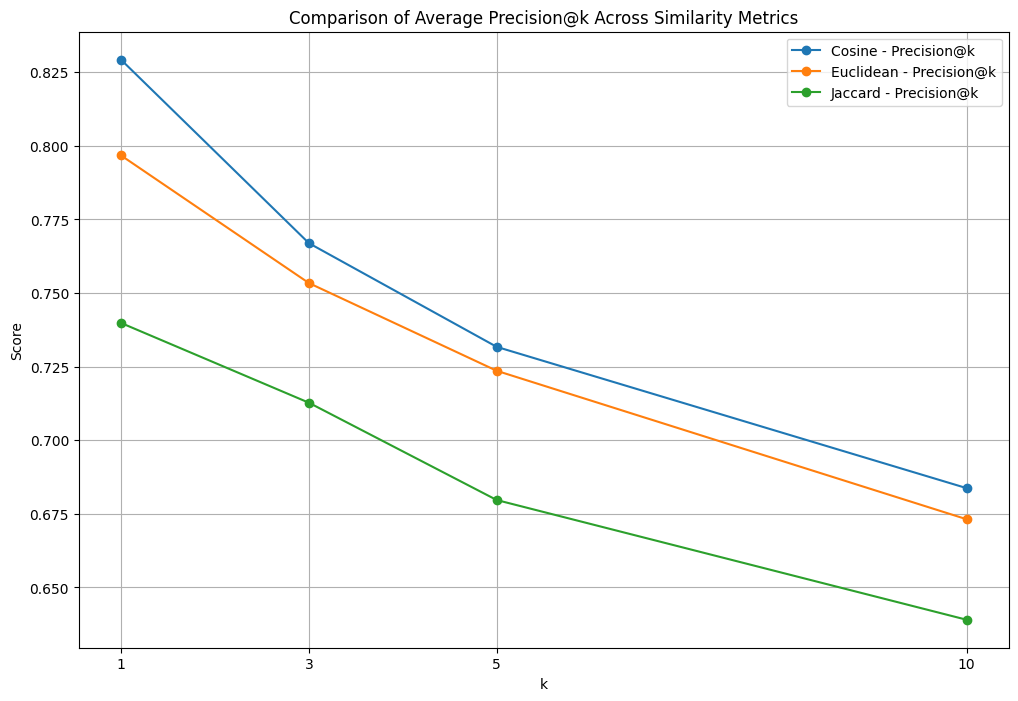

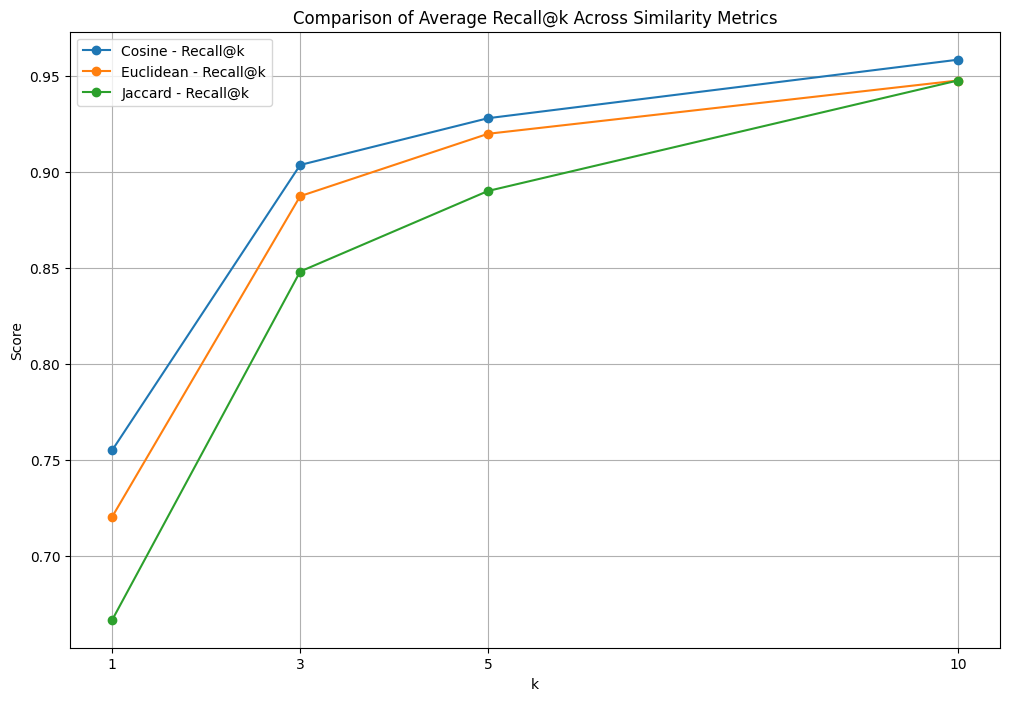

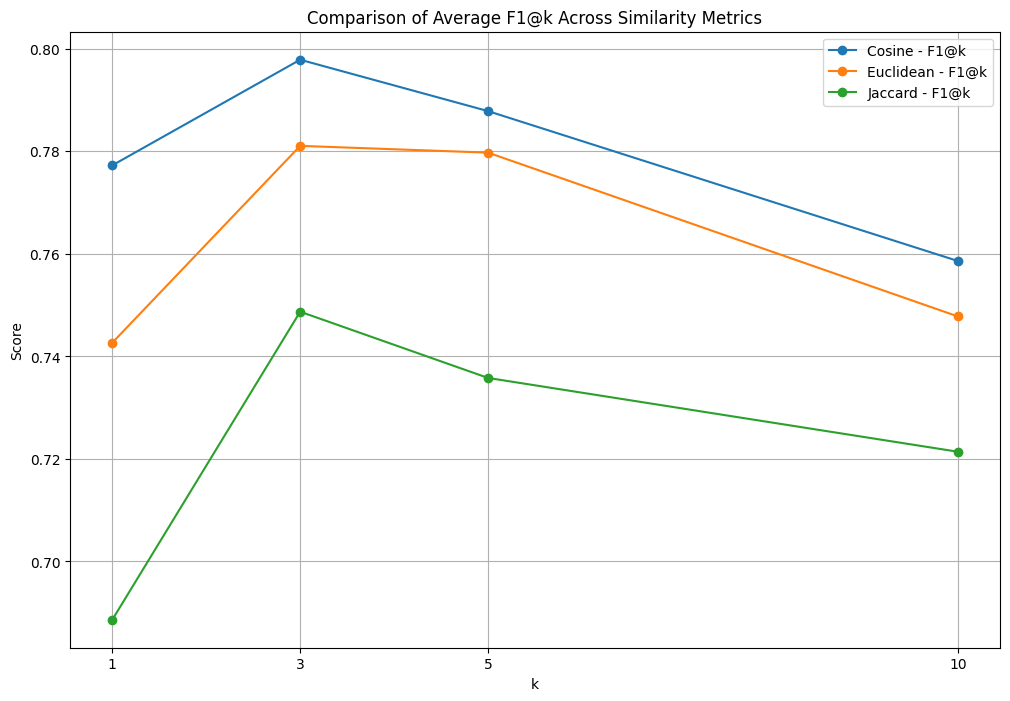


Analysis completed! Results saved to ./results_fasttext_finetuned/run_fasttext_finetuned_20250421_152150_all_text_0.5


In [12]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using Fine-tuned FastText embeddings')
    
    # Data and Paths
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use')
    parser.add_argument('--results_dir', type=str, default='./results_fasttext_finetuned',
                        help='Directory to save results')
    parser.add_argument('--model_path', type=str, default=None,
                        help='Path to load an existing FastText (.bin) model if --training_epochs is 0.')
    
    # Data Preprocessing
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')

    # FastText Training Arguments
    parser.add_argument('--training_epochs', type=int, default=0,
                        help='Number of epochs for FastText supervised training')
    parser.add_argument('--learning_rate', type=float, default=0.1,
                        help='Learning rate for FastText training')
    parser.add_argument('--embedding_dim', type=int, default=300,
                        help='Dimension of embeddings (should match pretrained vectors if used)')
    parser.add_argument('--word_ngrams', type=int, default=2,
                        help='Max length of word n-grams for FastText training')
    parser.add_argument('--loss_function', type=str, default='softmax', choices=['softmax', 'ns', 'hs'],
                        help='Loss function for FastText training')
    parser.add_argument('--top_k', type=int, default=10,
                        help='Number of similar requests to find for each test sample')

    args, unknown = parser.parse_known_args()
    results = main(args) 

### Training 20 epochs

Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...

Checking label distribution...
Number of unique labels found: 20

Ensuring pre-trained FastText vectors (.vec) are available for training input...
Pre-trained FastText vectors (cc.en.300.vec) not found, downloading...


Downloading: 1.33GB [02:06, 10.5MB/s]                            


Extracting vector file to /root/.fasttext/cc.en.300.vec...
Vectors extracted to /root/.fasttext/cc.en.300.vec
Created symlink to vectors in current directory

Preparing stratified split...
Falling back to random split

Label distribution in splits:
Label                     Train    Test
---------------------------------------
area/apiserver              191      32
area/cloudprovider          169      25
area/code-generation         45       9
area/conformance             16       0
area/custom-resources        13       3
area/dependency              66      11
area/e2e-test-framework      19       4
area/etcd                     3       2
area/ipvs                    43       4
area/kube-proxy              28       2
area/kubeadm                 45       2
area/kubectl                131      14
area/kubelet                330      42
area/provider/azure          62       5
area/provider/gcp            26       3
area/provider/openstack       5       0
area/provider/vmware          4

Formatting data: 100%|██████████| 1099/1099 [00:00<00:00, 5995.40it/s]

Data formatting complete.

Starting FastText supervised training...
  Train data: ./results_fasttext_finetuned/run_fasttext_finetuned_20250422_153630_all_text_0.5/train_fasttext.txt
  Pretrained vectors: /root/.fasttext/cc.en.300.vec
  Output model: ./results_fasttext_finetuned/run_fasttext_finetuned_20250422_153630_all_text_0.5/finetuned_model.bin
  Epochs: 20, LR: 0.1, Dim: 300, Ngrams: 2, Loss: softmax



Read 0M words
Number of words:  13018
Number of labels: 20
Progress: 100.0% words/sec/thread:  341107 lr:  0.000000 avg.loss:  0.534802 ETA:   0h 0m 0s  1.2% words/sec/thread:  108577 lr:  0.098823 avg.loss:  2.456073 ETA:   0h 1m41s% words/sec/thread:  189693 lr:  0.095312 avg.loss:  1.919567 ETA:   0h 0m55s words/sec/thread:  220032 lr:  0.092756 avg.loss:  1.721927 ETA:   0h 0m46s35s words/sec/thread:  302733 lr:  0.079840 avg.loss:  1.185637 ETA:   0h 0m29s 22.5% words/sec/thread:  308767 lr:  0.077472 avg.loss:  1.128042 ETA:   0h 0m27s 23.9% words/sec/thread:  311906 lr:  0.076105 avg.loss:  1.099294 ETA:   0h 0m27s 315142 lr:  0.074715 avg.loss:  1.068373 ETA:   0h 0m26s 318970 lr:  0.072951 avg.loss:  1.034350 ETA:   0h 0m25s 32.7% words/sec/thread:  328913 lr:  0.067324 avg.loss:  0.940079 ETA:   0h 0m22s 332116 lr:  0.063681 avg.loss:  0.890856 ETA:   0h 0m21s 0.881781 ETA:   0h 0m21s words/sec/thread:  333271 lr:  0.062343 avg.loss:  0.874807 ETA:   0h 0m20s 57.4% words/sec

Training complete. Model saved to ./results_fasttext_finetuned/run_fasttext_finetuned_20250422_153630_all_text_0.5/finetuned_model.bin

Loading FastText model from ./results_fasttext_finetuned/run_fasttext_finetuned_20250422_153630_all_text_0.5/finetuned_model.bin...
Model loaded. Dimension: 300

Generating embeddings using the loaded FastText model...


Generating embeddings: 100%|██████████| 123/123 [00:00<00:00, 2423.83it/s]



Finding similar requests and calculating metrics for different similarity types...

--- Processing Similarity Metric: Cosine ---
Calculating label-based metrics for cosine...

Label-based Metrics (Cosine):
Match Rate (at least one match): 0.9756
Average Precision@1: 0.9187
Average Recall@1: 0.8321
Average F1@1: 0.8594
Average Precision@3: 0.9214
Average Recall@3: 0.9031
Average F1@3: 0.8916
Average Precision@5: 0.9138
Average Recall@5: 0.9099
Average F1@5: 0.8917
Average Precision@10: 0.9016
Average Recall@10: 0.9316
Average F1@10: 0.8948
Average Label Overlap: 0.7392

--- Processing Similarity Metric: Euclidean ---
Calculating label-based metrics for euclidean...

Label-based Metrics (Euclidean):
Match Rate (at least one match): 0.9675
Average Precision@1: 0.9350
Average Recall@1: 0.8565
Average F1@1: 0.8810
Average Precision@3: 0.9051
Average Recall@3: 0.8991
Average F1@3: 0.8821
Average Precision@5: 0.9008
Average Recall@5: 0.9045
Average F1@5: 0.8857
Average Precision@10: 0.8894
A

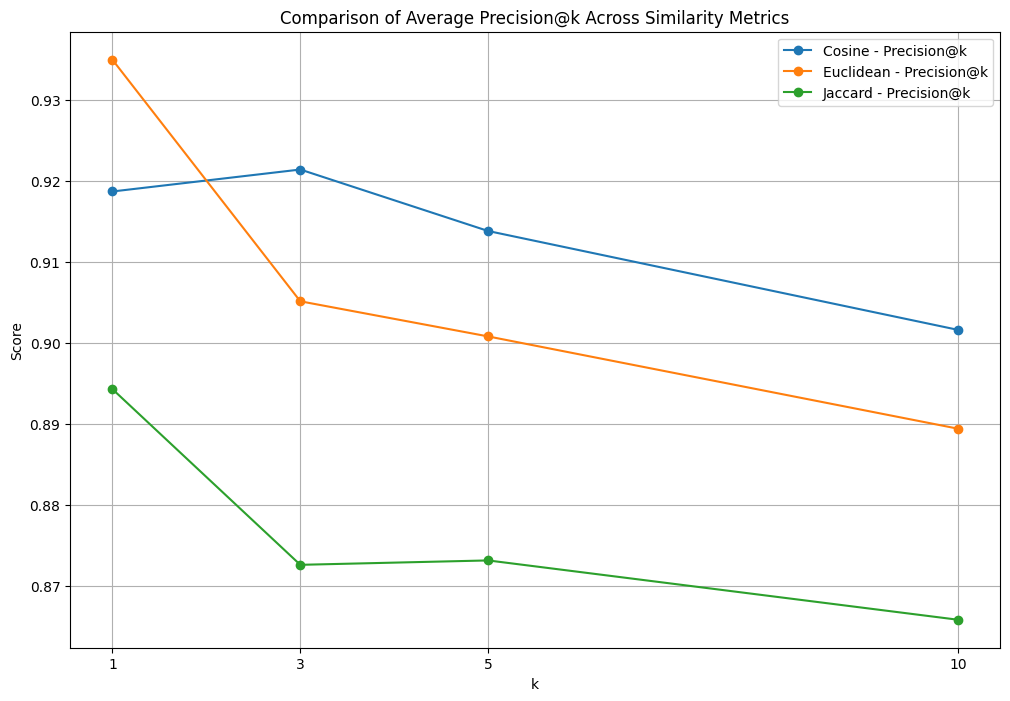

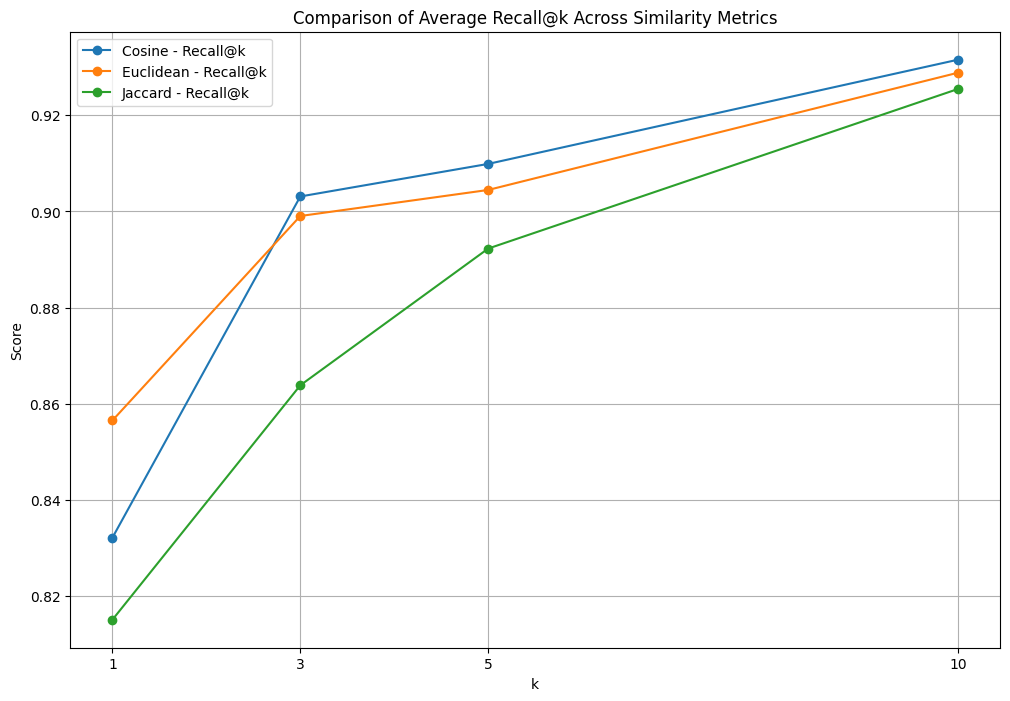

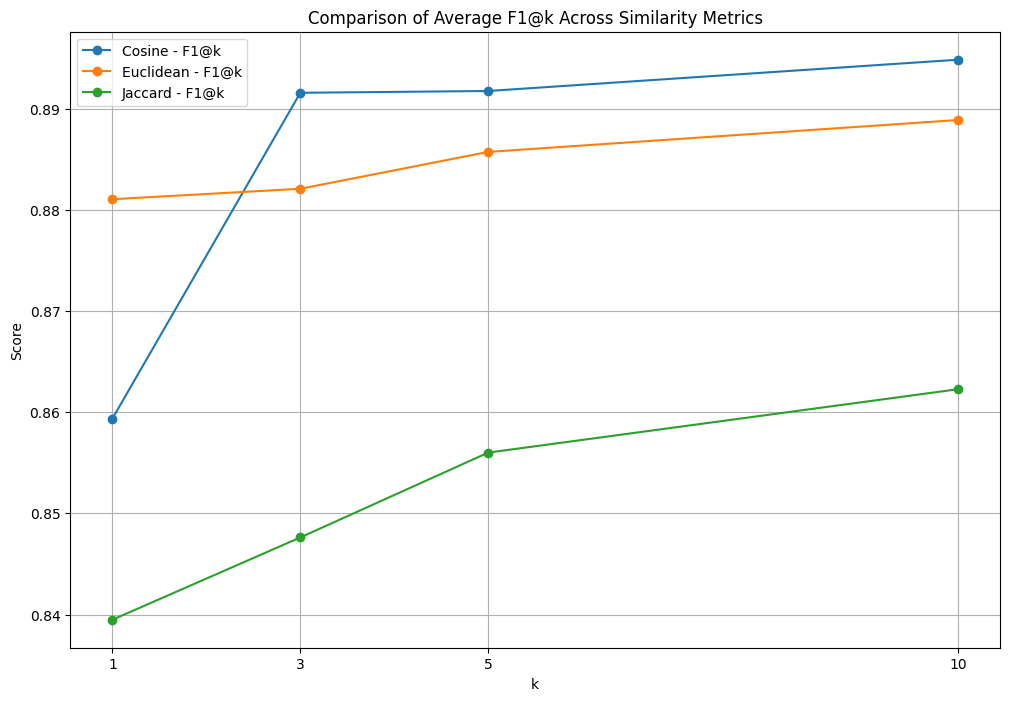


Analysis completed! Results saved to ./results_fasttext_finetuned/run_fasttext_finetuned_20250422_153630_all_text_0.5


In [2]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using Fine-tuned FastText embeddings')
    
    # Data and Paths
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use')
    parser.add_argument('--results_dir', type=str, default='./results_fasttext_finetuned',
                        help='Directory to save results')
    
    # Data Preprocessing
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')

    # FastText Training Arguments
    parser.add_argument('--training_epochs', type=int, default=20,
                        help='Number of epochs for FastText supervised training')
    parser.add_argument('--learning_rate', type=float, default=0.1,
                        help='Learning rate for FastText training')
    parser.add_argument('--embedding_dim', type=int, default=300,
                        help='Dimension of embeddings (should match pretrained vectors if used)')
    parser.add_argument('--word_ngrams', type=int, default=2,
                        help='Max length of word n-grams for FastText training')
    parser.add_argument('--loss_function', type=str, default='softmax', choices=['softmax', 'ns', 'hs'],
                        help='Loss function for FastText training')
    parser.add_argument('--top_k', type=int, default=10,
                        help='Number of similar requests to find for each test sample')

    args, unknown = parser.parse_known_args()
    results = main(args) 